## Overview

In this analysis, we explore a decision-making problem that we encounter in casino dice game. The goal is to find an optimal strategy that maximizes our total (cumulative) earnings over multiple rounds.

### Game Rules
* We start with 100 tries and a starting dice value of 1.
* Our dice has 20 sides.
* At each turn/round, we have two choices:
     * Keep the current value and collect that amount in euros.
     * Re-roll the dice, which replaces our current number with a new random number from 1 to 20.
* The number we choose to keep will be our new starting number for future rounds until we decide to replace it by rolling again.
* Each action (keeping or re-rolling) costs one try. The game ends when we run out of tries (100 total).

### Example Gameplay

**Starting Conditions:**

* Tries Left: 100
* Current Dice Value: 1
* Total Money Collected: 0

**Round 1:**

* Decision: Re-roll
* New Roll: 12
* Tries Left: 99
* Total Money Collected: 0
* New Starting Value for Next Round: 12

**Round 2:**

* Decision: Keep
* Tries Left: 98
* Total Money Collected: 12
* New Starting Value for Next Round: 12

**Round 3:**

* Decision: Re-roll
* New Roll: 8
* Tries Left: 97
* Total Money Collected: 12
* New Starting Value for Next Round: 8

**Round 4:**

* Decision: Keep
* Tries Left: 96
* Total Money Collected: 12 + 8 = 20
* New Starting Value for Next Round: 8

This process continues until all 100 tries are used up.

### When Should We Keep vs Re-roll?

The challenge is to determine the best strategy for deciding when to keep the current number and when to risk rolling again to maximize total earnings. The answer is not so obvious, since:

* Keeping a low number (for example 5) too early means we may miss out on much higher values later.
* Rolling too often means we waste tries and might end up with a worse value.

A **good strategy balances risk and reward**: keeping a high number to earn more but re-rolling when there's a good chance of getting an even better one.

## Mathematical Modeling and Python Implementation

### Define Variables & Notation

As shown above, at each round the player has 
* a starting/stored dice number $S_t$ at tries/time $t$.
* A choice between:
    1. Keeping $S_t$ and add it to total earnings.
    2. Re-roll and replace $S_t$ with a new roll (1...20)
* $Total\:earnings$ 

In [1]:
# Define game parameters
TOTAL_TRIES = 100  # Total rounds to play
DICE_SIDES = 20  # Fair 20-sided dice

From Probability theory we know that the expected value of rolling a fair n-sided dice is:
$$
E[X]=\frac{1+2+...+n}{n} = \frac{n+1}{2}
$$

For a 20-sided dice:

$$
E[X]=\frac{20+1}{2} = 10.5
$$

This is the expected value we have in each one of our re-rolls. Each roll is a **Random Experiment** that is not correlated to our current stored value $S_t$, the $Total\:Earnings$ or anything else.

We will create a python class `Dice`to encapsulate the dice logic.

In [2]:
import random

# setting random seed for reproducability
random.seed(10)

class Dice:
    """Represents a fair n-sided dice."""
    
    def __init__(self, sides=20):
        self.sides = sides

    def roll(self):
        """Simulates rolling the dice, returning a random integer between 1 and n."""
        return random.randint(1, self.sides)

    def expected_value(self):
        """Compute expected value of rolling the dice."""
        return (1 + self.sides) / 2

# Example Usage
dice = Dice(sides=20)
expected_value = dice.expected_value()
print(f"Expected dice roll value: {expected_value}")

Expected dice roll value: 10.5


### Possible Earnings range

Let's define the possible earnings range of this game.We will do that by examining the worst and best possible scenarios.

* Worst-Case Scenario (Always Re-roll = 0 Earnings).

    If a player never keeps any number and re-rolls for all 100 tries, they will never collect money, resulting in:

$$
Total\:Earnings = 0
$$

This is actually not a reasonable strategy, but it lets us define the range.

* Best-Case Scenario (Perfect Play = 1980 Earnings)

    The best possible scenario happens if:

    * We re-roll the first time, moving from 1 to 20.
    * We keep 20 for 99 rounds.

$$
Total\:Earnings = (0\times1) + (99\times20) = 1980
$$

So the earnings range for this game is $[0,1980]$

## Reasonable Strategies

* **Always Keep, never Re-roll**

    In this way, you will keep the initial starting value $1$ and collect it 100 times. This strategy always has
<br>
    $$ 
    Total\:Earnings = 100 \times 1 = 100
    $$
<br>

* **Roll Once, then Keep**

    This strategy aims at getting the expected value of one dice roll ($E[X]=10.5$) and collecting it for the remaining 99 tries.
<br>  
    $$Total\:Earnings = (0*1) + (99 * E[X]) = 99 * 10.5 = 1039,5$$
<br>    
 
* **Keep if Probability of Rolling Higher is Large**
    
    * We choose a probability threshold (e.g. 70%)
    * If the probability of rolling higher is large (e.g., above 70%), we re-roll.
    * Once the probability of improvement is small (e.g., below 70%), we keep the number and collect it for all remaining tries.

An initial thought might be to roll as far as it is **more probable** to get a higher number than the current stored value. In that case, we would choose a probability threshold of 50%. The idea behind this strategy:

* Since the expected value of a dice roll is 10.5, we should try to get at least that before keeping.
* We assume that once it's hard to roll better, we should stop re-rolling and lock in earnings.

As we will see, this is not optimal.
$$
P(X>S_t) = \frac{n-S_t}{n}
$$

In other words,the probability of rolling higher than the current stored value,in a fair dice, is equal to 

$$
\frac{dice\:sides\:higher\:than\:S_t}{total\:dice\:sides}
$$

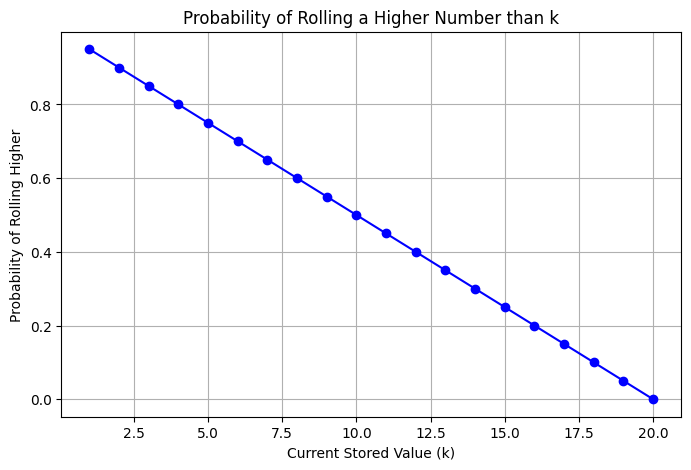

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

dice = Dice(sides=20)

# Compute probabilities for all possible values k = 1 to 20
k_values = np.arange(1, dice.sides + 1)
probabilities = [(dice.sides - k) / dice.sides for k in k_values]

# Plot probability of rolling a higher number than k
plt.figure(figsize=(8, 5))
plt.plot(k_values, probabilities, marker='o', linestyle='-', color='blue')
plt.xlabel("Current Stored Value (k)")
plt.ylabel("Probability of Rolling Higher")
plt.title("Probability of Rolling a Higher Number than k")
plt.grid(True)
plt.show()

The plot shows the probability of rolling a higher number than a given stored value $k$. As $k$ increases, the probability of improvement steadily decreases.

### Monte Carlo Simulation

To find the optimal probability threshold for deciding when to keep the current dice value versus re-rolling, we'll employ a Monte Carlo simulation. This technique uses repeated random sampling to estimate the potential outcomes of a process that involves randomness (like rolling the dice, in our case). By simulating the game numerous times, we can approximate the expected total earnings for different probability thresholds and identify the one that maximizes our returns.

In our approach, for each probability threshold ranging from 0.01 to 0.99, we'll conduct 10,000 simulations of the game. This extensive simulation will help us understand how different thresholds influence our expected total earnings.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# This function compares two floating-point numbers, returning False if they are approximately 
# equal within a specified tolerance, and True if a is significantly greater than b.
def is_greater(a, b, rel_tol=1e-9, abs_tol=0.0):
    if math.isclose(a, b, rel_tol=rel_tol, abs_tol=abs_tol):
        return False
    return a > b

# Define the probability-based strategy function
def probability_based_strategy(dice, tries=100, simulations=10000, probability_threshold=0.5):
    """Simulates a strategy where the player keeps if P(X > stored_value) is below the threshold."""
    earnings = []
    for i in range(simulations):
        tries_left = tries
        stored_value = 1  # Start with 1
        total_money = 0
        while tries_left > 0:
            
            prob_higher = (dice.sides - stored_value) / dice.sides  # P(X > stored_value)
            
            if is_greater(prob_higher,probability_threshold):  # If high probability, re-roll
                stored_value = dice.roll()
                tries_left -= 1
            else:
                total_money = stored_value * tries_left
                tries_left = 0  # Stop the game      
        earnings.append(total_money)
    return np.mean(earnings)

# Initialize dice
dice = Dice(sides=20)
simulations = 10000

# Run the strategy for different probability thresholds
probability_thresholds = np.arange(0.01, 1.0, 0.01)  # 1%, 2%, ..., 99%
results = []

for threshold in probability_thresholds:
    expected_earnings = probability_based_strategy(dice, simulations=simulations, probability_threshold=threshold)
    results.append((threshold, expected_earnings))
    print(f"Threshold: {threshold:.0%}, Expected Earnings: {expected_earnings:.2f}")



Threshold: 1%, Expected Earnings: 1595.87
Threshold: 2%, Expected Earnings: 1603.63
Threshold: 3%, Expected Earnings: 1602.56
Threshold: 4%, Expected Earnings: 1601.16
Threshold: 5%, Expected Earnings: 1756.74
Threshold: 6%, Expected Earnings: 1755.65
Threshold: 7%, Expected Earnings: 1756.48
Threshold: 8%, Expected Earnings: 1753.25
Threshold: 9%, Expected Earnings: 1754.46
Threshold: 10%, Expected Earnings: 1774.25
Threshold: 11%, Expected Earnings: 1772.87
Threshold: 12%, Expected Earnings: 1773.25
Threshold: 13%, Expected Earnings: 1771.14
Threshold: 14%, Expected Earnings: 1774.43
Threshold: 15%, Expected Earnings: 1758.47
Threshold: 16%, Expected Earnings: 1758.90
Threshold: 17%, Expected Earnings: 1757.74
Threshold: 18%, Expected Earnings: 1757.50
Threshold: 19%, Expected Earnings: 1758.31
Threshold: 20%, Expected Earnings: 1725.63
Threshold: 21%, Expected Earnings: 1726.86
Threshold: 22%, Expected Earnings: 1730.14
Threshold: 23%, Expected Earnings: 1728.42
Threshold: 24%, Expe

We observe that there are ranges of thresholds where the expected earnings are similar(e.g.1-4%,5-10%). To analyze these trends,we can visualize the data using a line plot.

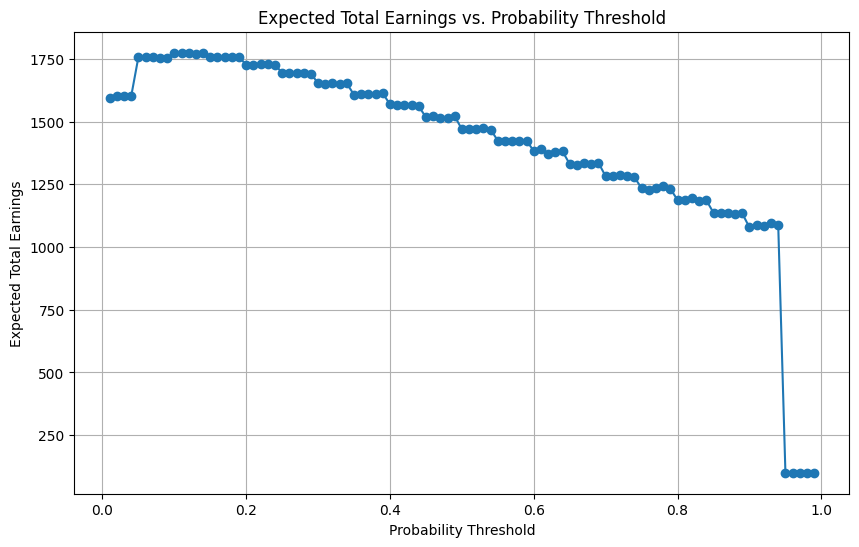

In [5]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Threshold', 'Expected_Earnings'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'].to_numpy(), results_df['Expected_Earnings'].to_numpy(), marker='o', linestyle='-')
plt.xlabel('Probability Threshold')
plt.ylabel('Expected Total Earnings')
plt.title('Expected Total Earnings vs. Probability Threshold')
plt.grid(True)
plt.show()

As we see, the 95-99% threshold range gives us relatively very low expected total earnings, equal to 100(This is actually the **Always Keep strategy**  we mentioned above). Let's exclude these values, to have a more clear view of the plot:

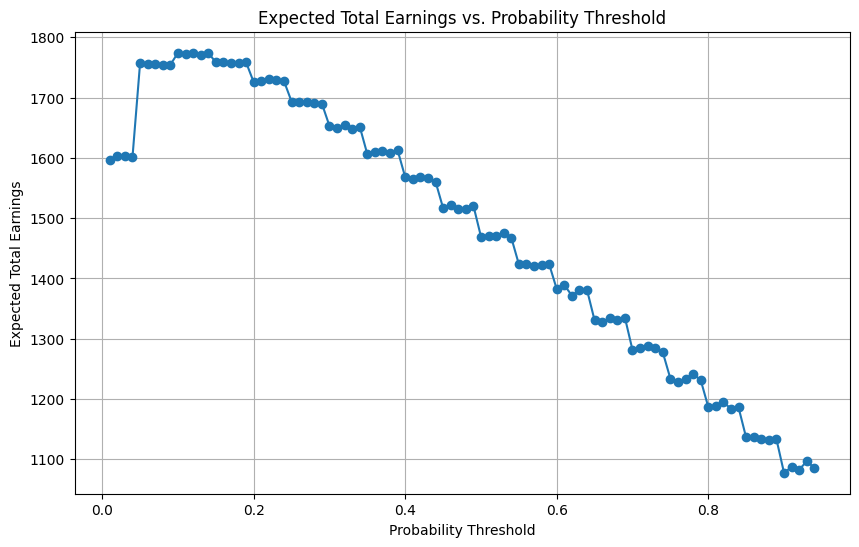

In [6]:
# Filter out rows where 'Expected_Earnings' is 100.00
filtered_results_df = results_df[results_df['Expected_Earnings'] != 100.00]

# Display the filtered DataFrame
plt.figure(figsize=(10, 6))
plt.plot(filtered_results_df['Threshold'].to_numpy(), filtered_results_df['Expected_Earnings'].to_numpy(), marker='o', linestyle='-')
plt.xlabel('Probability Threshold')
plt.ylabel('Expected Total Earnings')
plt.title('Expected Total Earnings vs. Probability Threshold')
plt.grid(True)
plt.show()

Observations: 

* **Optimal Threshold Range**: The expected total earnings peak in the probability threshold range $[10,14]$. So the best decision strategy lies within this interval.
* **Threshold relation with Dice Values**: The plot has 20 distinct levels, matching the 20 sides of the dice. This suggests that the threshold strategy would be expressed better with whole dice numbers (1-20), rather than percentages, since our decision is based on rolling a higher number.

### Finding the Optimal Threshold Number

Our decision-making problem can be now translated as determining the specific dice number we aim to reach. Instead of thinking in probabilities, we can rephrase the question as:

"What is the lowest dice number we should accept before stopping?"

Once we roll at least this number, we stop re-rolling and start collecting earnings.

We’ll use our previous simulation script to check which dice number matches the 10%-14% probability threshold range.

In [7]:
# Define the probability-based strategy function
def probability_based_strategy(dice, tries=100, simulations=10000, probability_threshold=0.5):
    """Simulates a strategy where the player keeps if P(X > stored_value) is below the threshold."""
    earnings = []
    min_dice_number = dice.sides
    for i in range(simulations):
        tries_left = tries
        stored_value = 1  # Start with 1
        total_money = 0
        while tries_left > 0:
            prob_higher = (dice.sides - stored_value) / dice.sides  # P(X > stored_value
            
            if is_greater(prob_higher,probability_threshold):  # If high probability, re-roll
                stored_value = dice.roll()
                tries_left -= 1
            else:
                if stored_value < min_dice_number:
                    min_dice_number = stored_value
                total_money = stored_value * tries_left
                tries_left = 0  # Stop the game      
        earnings.append(total_money)
    return np.mean(earnings), min_dice_number

# Initialize dice
dice = Dice(sides=20)
simulations = 10000

# Run the strategy for different probability thresholds
probability_thresholds = np.arange(0.01, 1.0, 0.01)  # 1%, 2%, ..., 99%
results = []

for threshold in probability_thresholds:
    expected_earnings, threshold_number = probability_based_strategy(dice, simulations=simulations, probability_threshold=threshold)
    results.append((threshold, expected_earnings, threshold_number))
    print(f"Threshold: {threshold:.0%}, Expected Earnings: {expected_earnings:.2f}, Threshold Dice Number: {threshold_number}")

Threshold: 1%, Expected Earnings: 1604.60, Threshold Dice Number: 20
Threshold: 2%, Expected Earnings: 1594.79, Threshold Dice Number: 20
Threshold: 3%, Expected Earnings: 1603.52, Threshold Dice Number: 20
Threshold: 4%, Expected Earnings: 1603.59, Threshold Dice Number: 20
Threshold: 5%, Expected Earnings: 1753.57, Threshold Dice Number: 19
Threshold: 6%, Expected Earnings: 1753.17, Threshold Dice Number: 19
Threshold: 7%, Expected Earnings: 1755.25, Threshold Dice Number: 19
Threshold: 8%, Expected Earnings: 1756.28, Threshold Dice Number: 19
Threshold: 9%, Expected Earnings: 1754.85, Threshold Dice Number: 19
Threshold: 10%, Expected Earnings: 1773.50, Threshold Dice Number: 18
Threshold: 11%, Expected Earnings: 1772.06, Threshold Dice Number: 18
Threshold: 12%, Expected Earnings: 1770.85, Threshold Dice Number: 18
Threshold: 13%, Expected Earnings: 1774.88, Threshold Dice Number: 18
Threshold: 14%, Expected Earnings: 1773.50, Threshold Dice Number: 18
Threshold: 15%, Expected Earn

Based on our analysis, the optimal strategy is to stop re-rolling once you achieve a dice value of 18 or higher. After you achieve that number, you can use the remaining tries to collect earnings. With this strategy, 
$$ 
Expected\:total\:earnings\approx 1773
$$

Which is quite favorable, considering the theoretical maximum earning is 1980.

### Analyzing the Threshold Dice Strategy with Extra Metrics

Now, we will run a Monte Carlo simulation to evaluate how different threshold numbers (1 to 20) affect our total earnings.

This time, we will store extra statistical metrics to better understand risk and variability.
For each threshold number, we will compute:

* **Expected Earnings**: The average total earnings across all simulations.

* **Standard Deviation**: A measure of variability—how much earnings fluctuate.

* **5th Percentile**: A "worst-case scenario" estimate (only 5% of games result in earnings lower than this).

* **95th Percentile**: A "best-case scenario" estimate (only 5% of games result in earnings higher than this).

By analyzing these metrics, we gain deeper insight into the risk-reward tradeoff of different threshold choices.

    Threshold  Expected_Earnings     Std_Dev  5th_Percentile  95th_Percentile
0           2          1102.9408  536.855027          294.00           1960.0
1           3          1140.1240  511.261821          297.00           1961.0
2           4          1188.6157  486.272326          396.00           1980.0
3           5          1228.7915  450.563399          495.00           1960.0
4           6          1281.8156  426.918751          594.00           1960.0
5           7          1337.6134  397.563845          693.00           1980.0
6           8          1379.7205  367.994975          792.00           1960.0
7           9          1423.8863  339.153319          891.00           1960.0
8          10          1475.1648  309.098877          990.00           1960.0
9          11          1519.5911  282.439526         1089.00           1980.0
10         12          1564.2189  253.171218         1176.00           1980.0
11         13          1611.4044  225.862295         1274.00    

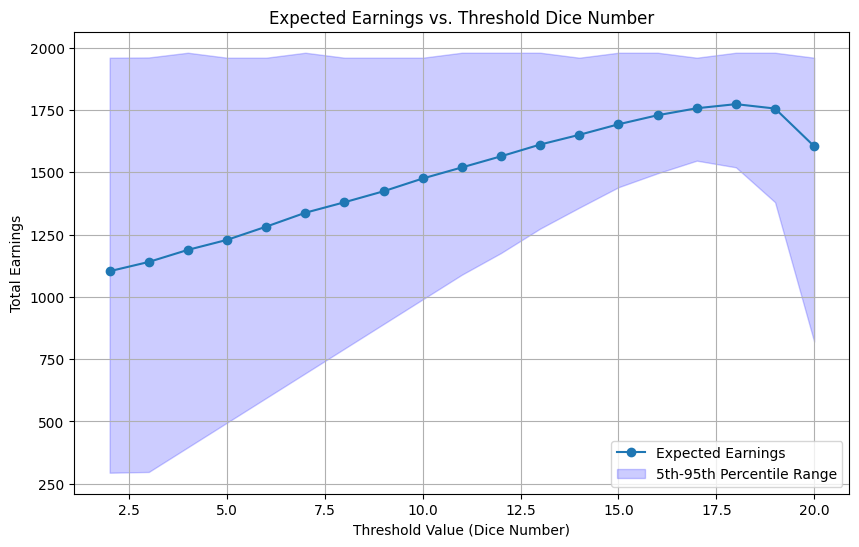

In [8]:
# Define the threshold-based strategy function
def threshold_based_strategy(dice, tries=100, simulations=10000, threshold_value=10):
    """Simulates the strategy where the player keeps only if the roll is at least threshold_value."""
    earnings = []

    for _ in range(simulations):
        tries_left = tries
        stored_value = 1  # Start with 1
        total_money = 0

        while tries_left > 0:
            if stored_value < threshold_value:  # If stored value is too low, roll again
                stored_value = dice.roll()
                tries_left -= 1
            else:
                total_money = stored_value * tries_left
                break  # Stop the game

        earnings.append(total_money)

    return {
        "Threshold": threshold_value,
        "Expected_Earnings": np.mean(earnings),
        "Std_Dev": np.std(earnings),
        "5th_Percentile": np.percentile(earnings, 5),
        "95th_Percentile": np.percentile(earnings, 95),
    }

# Initialize dice
dice = Dice(sides=20)
simulations = 10000

# Run the strategy for different threshold values (1-20)
threshold_values = np.arange(2, 21)
results = []

for threshold in threshold_values:
    results.append(threshold_based_strategy(dice, simulations=simulations, threshold_value=threshold))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
# Ensure numeric types and handle any NaN values
results_df = results_df.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values (if any)
results_df = results_df.dropna()
# Display the DataFrame
print(results_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'].to_numpy(), results_df['Expected_Earnings'].to_numpy(), marker='o', linestyle='-', label="Expected Earnings")
plt.fill_between(results_df['Threshold'], results_df['5th_Percentile'], results_df['95th_Percentile'], color='blue', alpha=0.2, label="5th-95th Percentile Range")
plt.xlabel('Threshold Value (Dice Number)')
plt.ylabel('Total Earnings')
plt.title('Expected Earnings vs. Threshold Dice Number')
plt.legend()
plt.grid(True)
plt.show()


Findings
* We verify that the optimal threshold is 18: Highest expected earnings (1772.52).

* Beyond 18, risk increases → Standard deviation jumps at 19 (191.44) and 20 (382.85).

* Waiting too long (19-20) leads to lower worst-case earnings → 5th percentile drops from 1520 (18) to 1387 (19) and 800 (20).

* Stopping too early (e.g., 2-6) results in much lower earnings (~1093-1279).

* Threshold 18 balances risk and reward best → High average earnings with stable worst-case outcomes.

* Threshold 17 has slightly lower standard deviation and a higher 5th percentile than 18, meaning it offers more stability in worst-case scenarios.

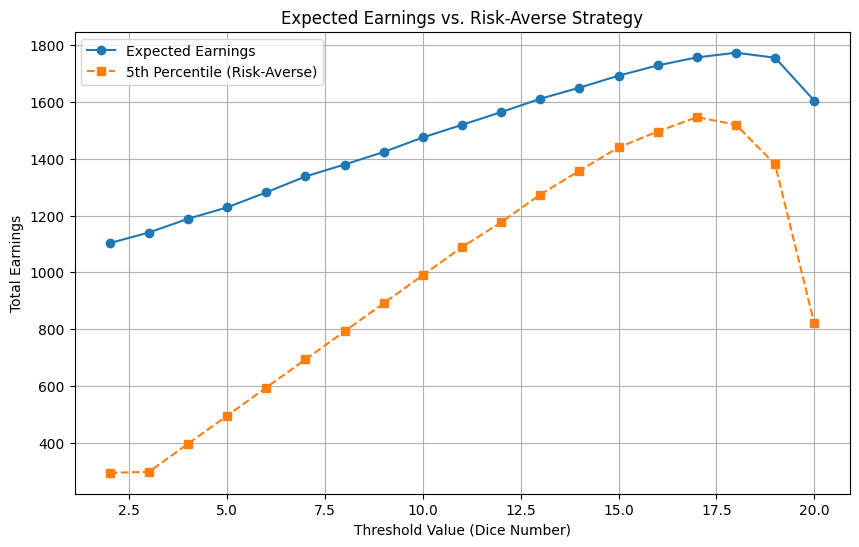

In [9]:
plt.figure(figsize=(10, 6))

# Plot Expected Earnings
plt.plot(results_df['Threshold'].to_numpy(), results_df['Expected_Earnings'].to_numpy(), marker='o', linestyle='-', label="Expected Earnings")

# Plot 5th Percentile
plt.plot(results_df['Threshold'].to_numpy(), results_df['5th_Percentile'].to_numpy(), marker='s', linestyle='--', label="5th Percentile (Risk-Averse)")

plt.xlabel('Threshold Value (Dice Number)')
plt.ylabel('Total Earnings')
plt.title('Expected Earnings vs. Risk-Averse Strategy')
plt.legend()
plt.grid(True)
plt.show()

### Risk-Averse Strategy: Maximizing "Safe" Earnings

* Risk-averse strategy peaks at 17, meaning it ensures the best worst-case scenario earnings (5th percentile).
* Choosing 17 ensures stability, while 18 offers slightly higher profits but introduces more variability.

### Alternative Approach: Calculating Expected Earnings with Probability

So far, we have used Monte Carlo simulations to estimate the expected earnings for each threshold. However, we can also calculate the expected earnings without simulations, using basic probability and statistics.

For each threshold T:

* We continue rolling until we reach T or higher.
* The probability of rolling T or higher is: 

$$
P(Roll \geq T) = \frac{21-T}{20} 
$$

* The expected number of rolls required to reach T or higher is:

$$
E[Rolls] = \frac{1}{P(Roll\geq T)}
$$

* Once we reach T or higher, we collect earnings for the tries left.

* The expected value of the dice roll, given that we roll T or higher, is:

$$
\frac{T+20}{2}
$$

* Thus, the expected earnings can be computed as:

$$
Expected\:Earnings = (100 - E[Rolls]) \times \frac{T+20}{2}
$$

This method provides a direct mathematical way to compute expected earnings without relying on thousands of simulations. Now, let’s calculate these values for all thresholds and compare them with the Monte Carlo results.

In [10]:
def calculate_expected_earnings_math(threshold, total_tries=100, dice_sides=20):
    """Calculates expected earnings mathematically without Monte Carlo simulation."""
    prob_reach_threshold = (dice_sides + 1 - threshold) / dice_sides
    expected_rolls = 1 / prob_reach_threshold  # Expected number of rolls before reaching threshold
    expected_value_given_threshold = (threshold + dice_sides) / 2  # Expected dice roll given we reach threshold
    expected_earnings = (total_tries - expected_rolls) * expected_value_given_threshold  # Total expected earnings
    return expected_earnings

# Add the column "Statistical_Expected_Earnings" to results_df
results_df["Statistical_Expected_Earnings"] = results_df["Threshold"].apply(lambda t: calculate_expected_earnings_math(t))
results_df.rename(columns={
    "Expected_Earnings": "Monte Carlo Expected Earnings",
    "Statistical_Expected_Earnings": "Statistical Expected Earnings"
}, inplace=True)

print(results_df[["Threshold", "Monte Carlo Expected Earnings", "Statistical Expected Earnings"]])

    Threshold  Monte Carlo Expected Earnings  Statistical Expected Earnings
0           2                      1102.9408                    1088.421053
1           3                      1140.1240                    1137.222222
2           4                      1188.6157                    1185.882353
3           5                      1228.7915                    1234.375000
4           6                      1281.8156                    1282.666667
5           7                      1337.6134                    1330.714286
6           8                      1379.7205                    1378.461538
7           9                      1423.8863                    1425.833333
8          10                      1475.1648                    1472.727273
9          11                      1519.5911                    1519.000000
10         12                      1564.2189                    1564.444444
11         13                      1611.4044                    1608.750000
12         1

As we notice, the values from Monte Carlo simulations and mathematical calculations are almost identical. Any small differences are because of randomness in the Monte Carlo approach.


## How Dice Sides and Total Tries Affect the Optimal Threshold

So far, we have found the best threshold for a 20-sided dice with 100 tries, but this threshold is not universal—it depends on the number of dice sides and available tries.

To explore this relationship, we will calculate the optimal threshold for different dice sides and total tries using the **mathematical method** (for efficiency reasons).

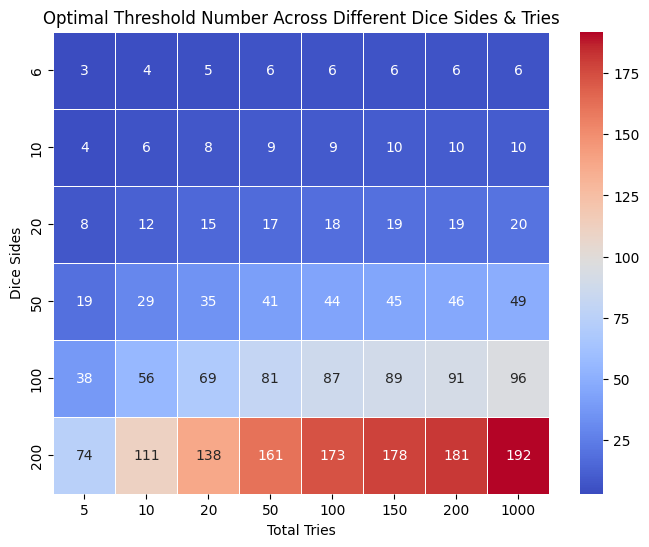

In [11]:
import seaborn as sns

def find_optimal_threshold(dice_sides, total_tries):
    """Finds the optimal threshold number for a given dice and total tries using mathematical expected value."""
    thresholds = np.arange(2, dice_sides + 1)  # Possible threshold values
    best_threshold = 2  # Start with lowest possible
    best_expected_earnings = 0

    for threshold in thresholds:
        expected_earnings = calculate_expected_earnings_math(threshold, total_tries, dice_sides)
        if expected_earnings > best_expected_earnings:
            best_expected_earnings = expected_earnings
            best_threshold = threshold
            
    return best_threshold

dice_sides_range = [6, 10, 20, 50, 100, 200]  
tries_range = [5, 10, 20, 50, 100, 150, 200, 1000]  

# Create an empty DataFrame to store optimal thresholds
heatmap_data = pd.DataFrame(index=dice_sides_range, columns=tries_range)

# Compute optimal threshold for each pair
for dice_sides in dice_sides_range:
    for total_tries in tries_range:
        heatmap_data.loc[dice_sides, total_tries] = find_optimal_threshold(dice_sides, total_tries)

# Convert values to integers
heatmap_data = heatmap_data.astype(int)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Total Tries")
plt.ylabel("Dice Sides")
plt.title("Optimal Threshold Number Across Different Dice Sides & Tries")
plt.show()

The heatmap above shows:

* **More dice sides -> Higher optimal threshold**: When the dice has more possible values, it makes sense to wait for a higher number.
* **More tries -> Higher optimal threshold**: With more chances to roll, players can afford to be more selective and wait for a better value.

This analysis shows that the optimal threshold is **dynamic**, changing based on game parameters.